# Intro

This script is based on this tutorial from torchmil: https://torchmil.readthedocs.io/en/stable/examples/data_representation/

### Import dataset

In [ ]:
import torch
from torchvision import datasets, transforms

# Load MNIST dataset
mnist = datasets.MNIST(
    "/tmp/", train=True, download=True, transform=transforms.ToTensor()
)

# Extract features and labels
data = mnist.data.view(-1, 28 * 28) / 255
labels = mnist.targets

100%|██████████| 9.91M/9.91M [00:01<00:00, 9.70MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 226kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.58MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.09MB/s]


### Get a bag

In [2]:
from tensordict import TensorDict

# Select 10 random indices
indices = torch.randperm(data.size(0))[:10]

bag = TensorDict(
    {"X": data[indices], "y_inst": labels[indices], "Y": labels[indices].max()}
)
bag

TensorDict(
    fields={
        X: Tensor(shape=torch.Size([10, 784]), device=cpu, dtype=torch.float32, is_shared=False),
        Y: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.int64, is_shared=False),
        y_inst: Tensor(shape=torch.Size([10]), device=cpu, dtype=torch.int64, is_shared=False)},
    batch_size=torch.Size([]),
    device=None,
    is_shared=False)

### Create toy dataset
4 and 5 are positive instances (y=1, y=0 otherwise). Label of the bag is 1 if it contains 4 or 5, label of bag is 0 otherwise

In [12]:
from torchmil.datasets import ToyDataset

# Define positive labels
obj_labels = [4, 5]  # Digits 4 and 5 are considered positive

# Create MIL dataset
toy_dataset = ToyDataset(data, labels, num_bags=100, obj_labels=obj_labels, bag_size=10)

# Retrieve a bag
bag = toy_dataset[0]
bag

TensorDict(
    fields={
        X: Tensor(shape=torch.Size([10, 784]), device=cpu, dtype=torch.float32, is_shared=False),
        Y: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.int64, is_shared=False),
        y_inst: Tensor(shape=torch.Size([10]), device=cpu, dtype=torch.int64, is_shared=False)},
    batch_size=torch.Size([]),
    device=None,
    is_shared=False)

### Visualize bags

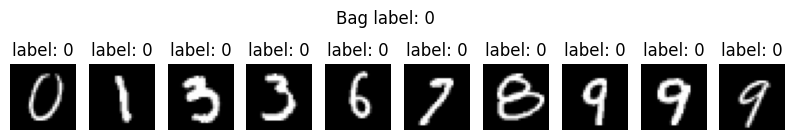

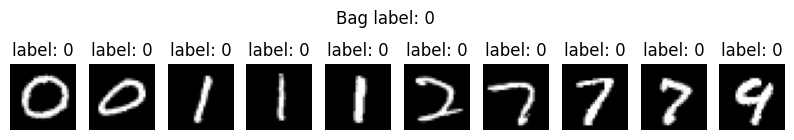

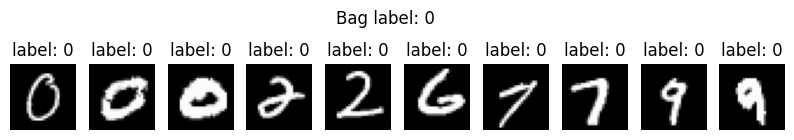

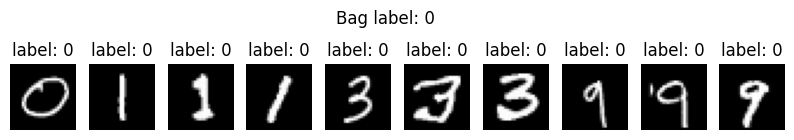

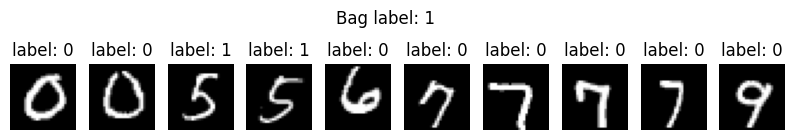

In [13]:
import matplotlib.pyplot as plt


def plot_bag(bag):
    bag_size = len(bag["X"])
    fig, axes = plt.subplots(1, bag_size, figsize=(bag_size, 1.8))
    for i in range(bag_size):
        ax = axes[i]
        ax.imshow(bag["X"][i].view(28, 28), cmap="gray")
        ax.set_title(f"label: {bag['y_inst'][i].item()}")
        ax.axis("off")
    fig.suptitle(f'Bag label: {bag["Y"].item()}')
    plt.show()


for i in range(5):
    bag = toy_dataset[i]
    plot_bag(bag)


### Create mini-batches

Bags in a batch may be of different length, that's why they are padded with zeros to max length in a batch

In [21]:
from torchmil.datasets import ToyDataset

# Define positive labels
obj_labels = [4, 5]  # Digits 4 and 5 are considered positive

# Create MIL dataset
toy_dataset = ToyDataset(data, labels, num_bags=100, obj_labels=obj_labels, bag_size=(8, 10))   # Randomly sampling between 4 and 10 instances per bag

# Retrieve a bag
bag = toy_dataset[0]
bag

TensorDict(
    fields={
        X: Tensor(shape=torch.Size([8, 784]), device=cpu, dtype=torch.float32, is_shared=False),
        Y: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.int64, is_shared=False),
        y_inst: Tensor(shape=torch.Size([8]), device=cpu, dtype=torch.int64, is_shared=False)},
    batch_size=torch.Size([]),
    device=None,
    is_shared=False)

In [22]:
from torchmil.data import collate_fn

bag_list = [toy_dataset[i] for i in range(4)]
batch = collate_fn(bag_list)
batch

TensorDict(
    fields={
        X: Tensor(shape=torch.Size([4, 9, 784]), device=cpu, dtype=torch.float32, is_shared=False),
        Y: Tensor(shape=torch.Size([4]), device=cpu, dtype=torch.int64, is_shared=False),
        mask: Tensor(shape=torch.Size([4, 9]), device=cpu, dtype=torch.uint8, is_shared=False),
        y_inst: Tensor(shape=torch.Size([4, 9]), device=cpu, dtype=torch.int64, is_shared=False)},
    batch_size=torch.Size([]),
    device=None,
    is_shared=False)

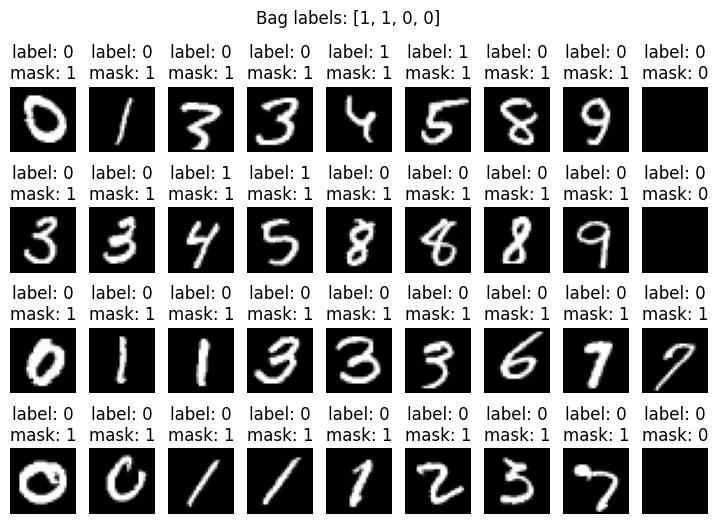

In [23]:
def plot_batch(batch):
    batch_size = len(batch["X"])
    bag_size = len(batch["X"][0])
    fig, axes = plt.subplots(batch_size, bag_size, figsize=(bag_size, 1.5 * batch_size))
    for i in range(batch_size):
        for j in range(bag_size):
            ax = axes[i, j]
            ax.imshow(batch["X"][i][j].view(28, 28), cmap="gray")
            ax.set_title(
                f"label: {batch['y_inst'][i][j].item()}\nmask: {batch['mask'][i][j].item()}"
            )
            ax.axis("off")
        fig.suptitle(f'Bag labels: {batch["Y"].tolist()}')


plot_batch(batch)
